# Yu-Gi-Oh Deck Analysis for 2018

Developed by: Jacob Powell

Start: 12/11/2018

End: 12/30/2018

For this project I wanted to analyze several different Yu-Gi-Oh Decks and compare them by using several different factors: Good or Bad starting hands, Attack, Defense, Consistency, Versatility, and Recovery. However, a question popped up in my head, "How would I be able to compare the interactions between these decks and analyze them more effectively?" This is why I decided to use Python as a medium to assist me in finding these differences and identifying potential similarities among these decks.

For starting I had to import several libraries and my data so as to be able to begin my work. 

In [9]:
import pandas
import matplotlib
import numpy
import matplotlib.pyplot
import seaborn
data = pandas.read_excel('Deck_Analysis_data.xlsx')
#data

I began with trying to find the correlation for all the entries and then using that data to create a heatmap that may be able to help me identify any outliers among the data. If this does not work I will try to take the mean of the Attack, Defense, Consistency, Versatility, and Recovery rankings and use that data for comparison.

In [10]:
quantifier = data.iloc[:, 1:]
normalization = (quantifier - quantifier.mean())/quantifier.std()
# normalization

However to find the distance between points using the Euclidean distance function, I would have to use a method from a previous project.

In [11]:
#Creating a Distance function:
def dist(i,j):     # The Function that works with finding the distance between i and j
    quant = data.iloc[:, 1:] #the quantitative cells
    cat = data.iloc[:, :0]   #the categorical cells
    norm = (quant - quant.mean())/quant.std() #normalized cells for the quant cells
    hdistance = (cat.iloc[i] != cat.iloc[j]).sum()
    
    qdistance = ((norm.iloc[i] - norm.iloc[j]).abs()).sum()
    return hdistance + qdistance

This method will be able to assist in the calculations between two points and allow me to form a distance matrix. With this matrix, I will then be able to take the correlation of the data and form a heatmap with the data.

In [12]:
matrix = pandas.DataFrame(index = data.index, columns = data.index, dtype = float)
for i in range(len(matrix.index)):
    for j in range(i):
        matrix.iloc[i,j] = dist(i,j)
        matrix.iloc[j,i] = dist(j,i)
# matrix

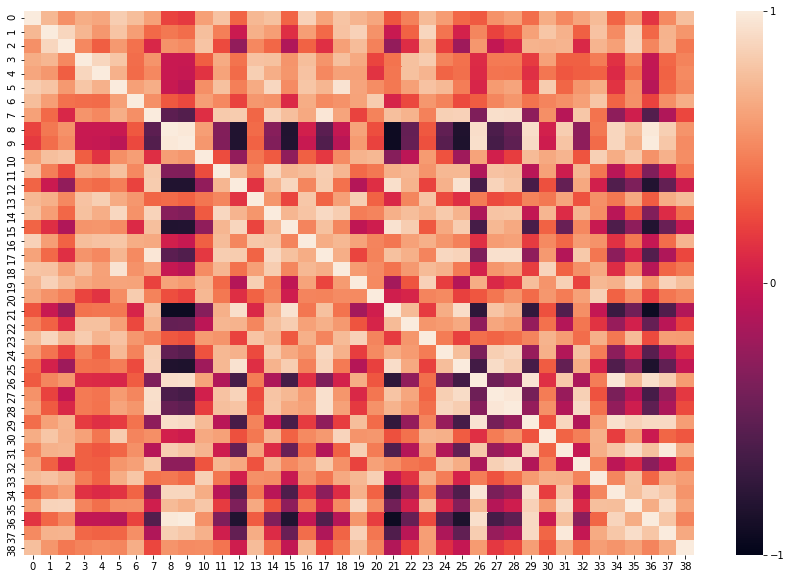

In [13]:
correlation = matrix.corr()
matplotlib.pyplot.figure(figsize = (15,10))
label_ticks = range(-1, 2)
correlmap = seaborn.heatmap(correlation, vmin = -1, vmax = 1, xticklabels=correlation.index, yticklabels=correlation.index, cbar_kws={'ticks': label_ticks})
correlmap

As you can see from this information there is definitely interaction going on between all the decks. However there is some changes in the data for example numbers 8,9 27, and 28 have some form of correlation that is very close to the fold. So there may be some sort of issue with those decks or in generality.

# What are the best decks?

In order to determine the best decks we have to first look at the data and see if any of the points share a single point or not. If most decks align on a single point, then we may be able to identify the top five best decks depending on whether that point is the only one in which all decks share. Yet, if the decks share more than one we will have a more difficult time in identifying the best decks. If it comes to this we will have to classify the decks by a mean score of their five main categories.

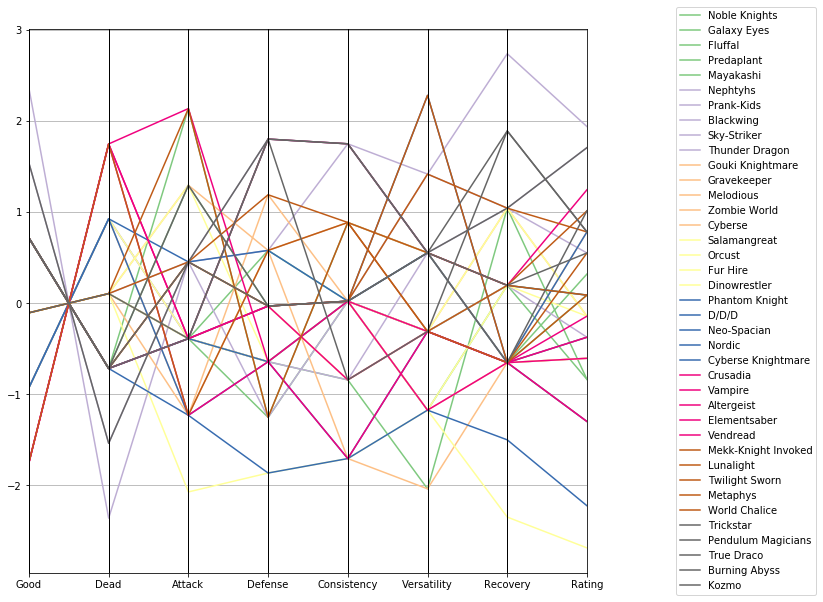

In [14]:
from pandas.plotting import parallel_coordinates
parallel_matrix = normalization.copy()
parallel_matrix['Decks'] = data.Decks
matplotlib.pyplot.figure(figsize = (10,10))
parallel_coordinates(parallel_matrix, 'Decks', normalization.columns, colormap = matplotlib.pyplot.cm.Accent)
matplotlib.pyplot.legend(loc = 'center left', bbox_to_anchor = (1.15, 0.5))

As we can see many of these decks share the same paths and most if not all meet at more than one single point. However, what do the top 5 highest rated decks all have in common? For this we will have to go about calculating the mean and deriving a score for in which we can use to track the top 5 and give a general overall rating to each deck. Once done we can then verify what those top 5 decks are.

In [15]:
table = data.copy()
mean = []
for i in range(len(table)):
    mean.append((table.Attack[i] + table.Defense[i]+table.Consistency[i]+table.Recovery[i]+table.Versatility[i])/5)
table['Mean'] = mean
table = table.sort_values(by = 'Mean', ascending = False)

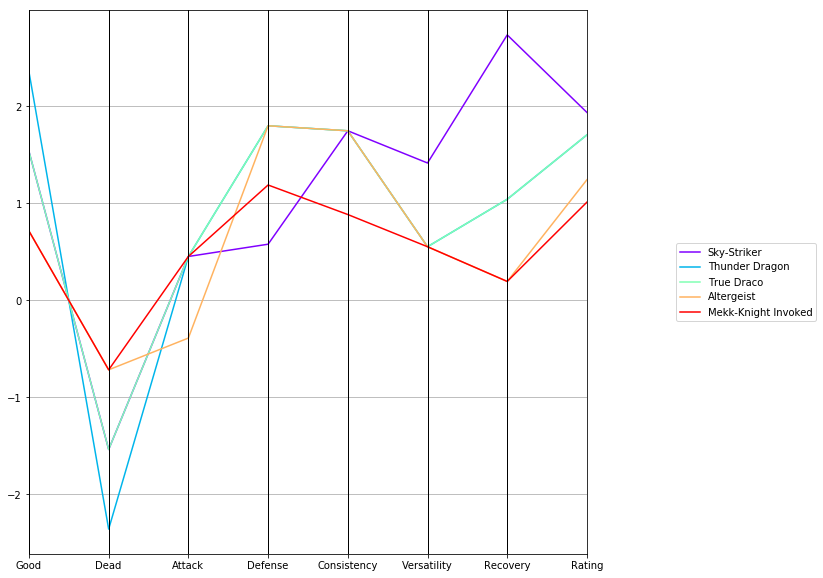

In [16]:
parallel_matrix2 = normalization.copy()
parallel_matrix2['Decks'] = table.Decks
parallel_matrix2['Mean'] = table.Mean
paralel_matrix2 = parallel_matrix2.sort_values(by = 'Mean', ascending = False)
top5 = paralel_matrix2.iloc[:5,:]
matplotlib.pyplot.figure(figsize = (10,10))
parallel_coordinates(top5, 'Decks', normalization.columns, colormap = matplotlib.pyplot.cm.rainbow)
matplotlib.pyplot.legend(loc = 'center left', bbox_to_anchor = (1.15, 0.5))

From this we can see that the top 5 decks are Sky-Striker, Thunder Dragons, Altergeist, True Draco, and Trickstar. Yet, we see that all these decks share one common point, Consistency. When playing in this game it is true having a consistent deck will be able to boost a decks competitive level. Since due to the consistency being higher it stops players from having dead hands in which they cannot do anything with their cards during the game and it increases their chances at winning.

However does each deck within the top five best decks reside in a different category along with other decks? If so we may have to see if there is any form of grouping in which they share.

# Determining Grouping

In [17]:
import sklearn.cluster
import sklearn.manifold
import nose.tools

When it comes to determining the grouping of the power of each deck variable we will be using K-Means clustering in assistance to help us determine whether our data will follow more of a linear pattern within its grouping or not. If it does follow a more linear pattern then we can tell that each deck has a certain power rating that has been crept out of the meta. However, if the data follows another pattern, whether it be exponential or no pattern, we will be able to assess whether the pattern is significant or not.

*Power Creep: When a Decks overall power and rating are significant now but due to new decks being developed they soon become overwhelmed and are no longer considered as powerful as they once were*

In [44]:
km = sklearn.cluster.KMeans(n_clusters = 7)
labels = km.fit_predict(normalization)
new_table = table.copy()
new_table['Cluster'] = labels
new_table = new_table.sort_values(by = 'Cluster', ascending = True)

In [45]:
mdsinits = normalization.loc[:, ['Versatility', 'Recovery','Consistency','Attack', 'Defense']]
ms = sklearn.manifold.MDS(n_components = 2, dissimilarity = 'euclidean', \
                         eps = 0, max_iter = 1000, n_init = 1)
#---------------------------------------------------------------------------
red_data = pandas.DataFrame(ms.fit_transform(normalization, mdsinits), columns = ['X', 'Y'])
dist_table = pandas.DataFrame(columns = ['Rating', 'X', 'Y'])
dist_table.Rating = table.Rating
dist_table.X = red_data.X
dist_table.Y = red_data.Y
new_table['X'] = abs(red_data.X)
new_table['Y'] = abs(red_data.Y)

We will be trying to break the decks into seven different clusters and try to identify them by their Attack, Defense, Consistency, Recovery, and Versatitility. Once done we will be able to plot the information and then develop the grouping.

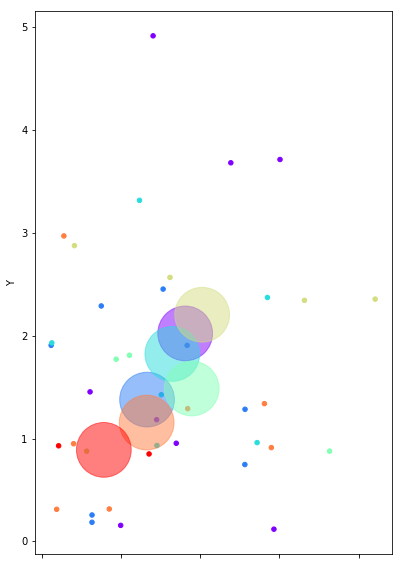

In [46]:
plot = new_table.plot.scatter(c= 'Cluster', x = 'X', y = 'Y', cmap = matplotlib.pyplot.cm.rainbow, figsize = (10,10))
groups = new_table.groupby('Cluster')
centroid = groups.mean()
centroid.plot.scatter(c = centroid.index, x = 'X', y = 'Y', cmap = matplotlib.cm.rainbow, s = 3000, ax = plot, alpha = .5)
plot.figure.axes[1].remove()
plot.figure.axes[1].remove()

As we see the clusters seem to follow a linear pattern, thus showing there is some form of power creep. However is that what the general clusters look like or is it their centroids as well? If they are linear then this is a definite observation on how power creep is attributed to these variables and on how some of the decks are better due to one variable: Consistency.

In [34]:
newCentTab = pandas.DataFrame(centroid.X, columns = ['X', 'Y'])
newCentTab.Y = centroid.Y
newCentTab

,X,Y
Cluster,,
0,2.106723,1.715591
1,2.718226,1.197849
2,1.096682,1.413387
3,1.620211,1.053535
4,1.173096,1.392930


So from what we can tell that as consistency rises, then it is more than likely due to a deck that has a higher power creep standard and is now leading to be the top of its deck rating. Overall, we still can say that due to the variable of consistency,  a deck will outperform another if its consistency is higher than another. 

# Conclusion

From all of this information we can take away is that the top tiering decks or most well performing decks are all due to the its consistency. However what does this mean for as a result in power creep and the future of other decks? Well in the future these decks will become less powerful due to some overall hit on the banlist and will suffer some hit to their consistency making them no longer a top tier deck. Thus meaning that they will be power crept out of the game but in a matter of time, whether it be long or short.

But what does this mean for the remainder of the year? For this we can see that for the remainder of this year the top five decks will be Sky Striker, Thunder Dragons, Altergeist, Mekk-Knight Invoked, and True Draco. Even though two of these decks are now considered rouge variants or lower tiers, their abilities to perform in a competition are better than most other decks of this past year. Yet given time, we will see that these decks Mekk-Knight Invoked and True Draco, our two rouge variants will be no longer considered meta and may be forgotten. Yet these decks for now will go on to take top spots in the competitions all around the world, and for our next year, 2019, we will have to see what happens. 

Will these decks defy all odds and stay relevant for competitive use or will they fall out of favor and be cast out? Well that is up to the players and how the banlist(s) of 2019 develop.

# Credits for Data:


Data obtained from the following YouTubers:
- El Exordio del Duelista
- Ricon del Duelista